In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.misc
import keras
import keras.applications
import tensorflow as tf
import keras.backend as K

plt.style.use('ggplot')

%matplotlib inline

#  Визуализация работы сети

# Визуализация

Есть несколько способов понять что же на самом деле выучила сеть:

* Визуализация фильтров
* Карты активации
* Нахождение изображений максимизирующих класс
* Генерация изображений максимизирующих активацию нейрона

In [35]:
session = tf.InteractiveSession()
model = keras.applications.VGG16(include_top=True, weights='imagenet')

In [53]:
from keras.utils import plot_model
from IPython.core.display import HTML
plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)
HTML('<div style="overflow: scroll"><img src="model.png" width="100%"/></div>')

#  Визуализация фильтров

Фильтры первого слоя сети можно визуализировать напрямую.

Фильтры первого слоя сети


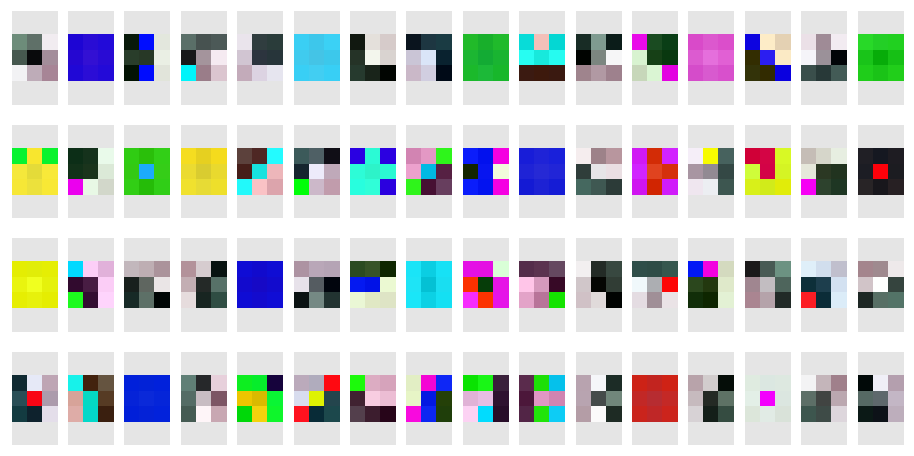

In [26]:
import keras
import keras.applications
import tensorflow as tf

first_conv_layer = model.layers[1]
kernels = first_conv_layer.weights[0]
w = kernels.value().eval(session=session)

fig, axes = plt.subplots(4, 16, sharex=True, sharey=True, figsize=(16, 8))

print('Фильтры первого слоя сети')

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        kernel_index = i * 16 + j
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(w[:, :, :, kernel_index])

# Карты активации слоёв

Очень полезной техникой является визуализация карт актвации слоёв. Для примера возьмём следующее изображение:

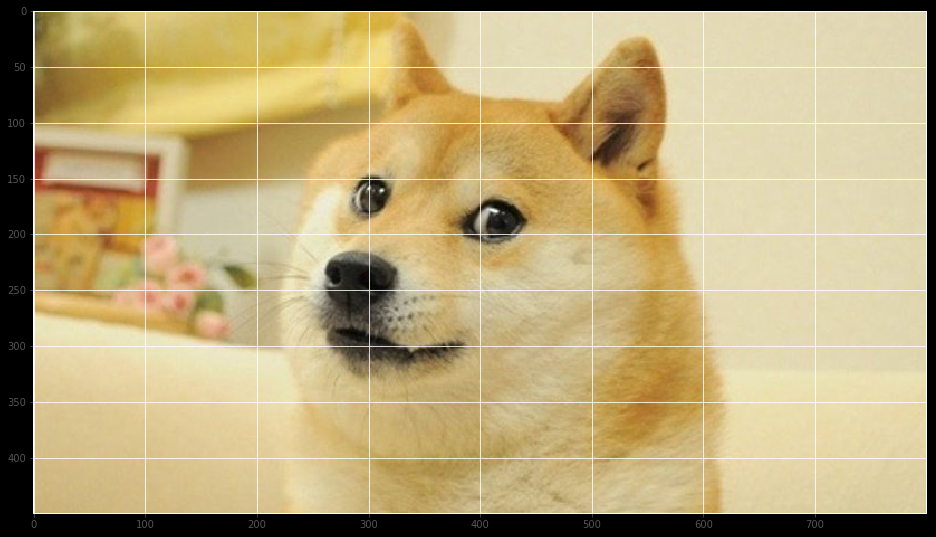

In [486]:
import urllib.request
from PIL import Image

url = 'http://i0.kym-cdn.com/entries/icons/mobile/000/013/564/doge.jpg'
response = urllib.request.urlopen(url)
image = Image.open(response)

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image)

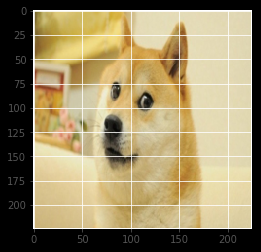

In [487]:
def preprocess_image(image):
    arr = np.asarray(image)
    arr = scipy.misc.imresize(arr, (224, 224))
    return np.expand_dims(arr, 0)

model_input = preprocess_image(image)
plt.imshow(model_input[0])

In [488]:
from keras.applications.vgg16 import decode_predictions

predicted_classes = model.predict(model_input)
decode_predictions(predicted_classes, top=3)

[[('n02109961', 'Eskimo_dog', 0.54064709),
  ('n02110185', 'Siberian_husky', 0.24141307),
  ('n04209239', 'shower_curtain', 0.032066863)]]

In [492]:
def build_activation_map_model(model, target_layer_name):
    target_layer = model.get_layer(target_layer_name)   
    activation_maps = keras.layers.Lambda(lambda x: tf.image.resize_images(x, (224, 224)))(target_layer.output)
    return keras.models.Model(model.input, activation_maps)

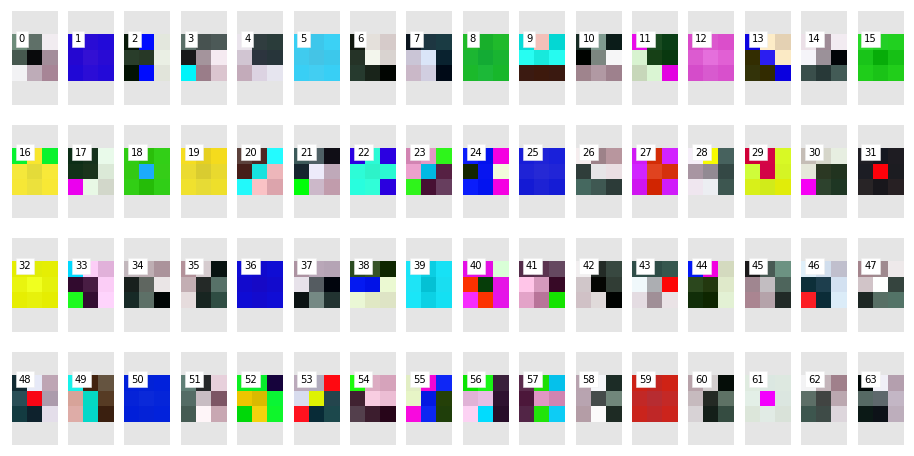

In [54]:
fig, axes = plt.subplots(4, 16, sharex=True, sharey=True, figsize=(16, 8))

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        kernel_index = i * 16 + j
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.text(0, 0, kernel_index, bbox={'facecolor': 'white', 'pad': 3})
        ax.imshow(w[:, :, :, kernel_index])

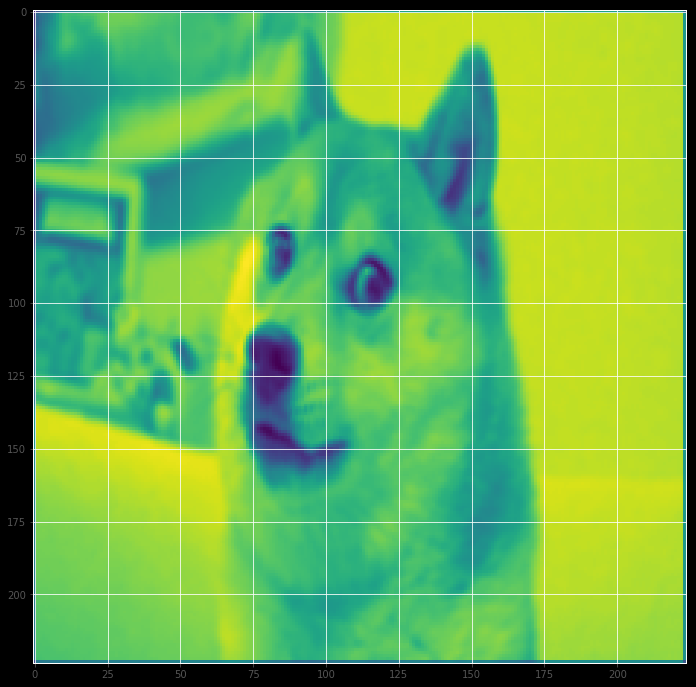

In [500]:
activation_maps_model = build_activation_map_model(model, 'block1_conv1')
activation_maps = activation_maps_model.predict(model_input)

fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(activation_maps[0, :, :, 31])

# Визуализация верхнего слоя

Визуализация карт активации верхнего слоя позволяет понять какие признаки приходят на вход классификатора

In [235]:
activation_maps_model = build_activation_map_model(model, 'block5_conv3')
activation_maps = activation_maps_model.predict(model_input)[0]
activation_maps.shape

(224, 224, 512)

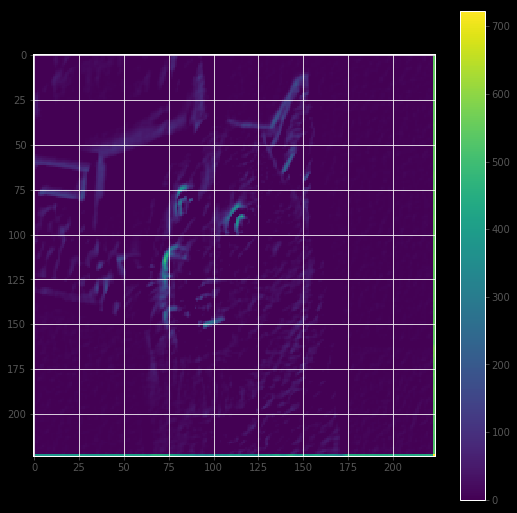

In [502]:
fig, ax = plt.subplots(figsize=(9, 9))
a = ax.imshow(activation_maps[0, :, :, 0])
fig.colorbar(a)

In [241]:
def generate_masked_image(image, activation_map):
    """
    Добавим отнормированную карту активации в качестве alpha канала
    """
    image = image / 255
    max_activation = np.max(activation_map)
    mask = activation_map / max_activation
    
    return np.dstack([img, mask])

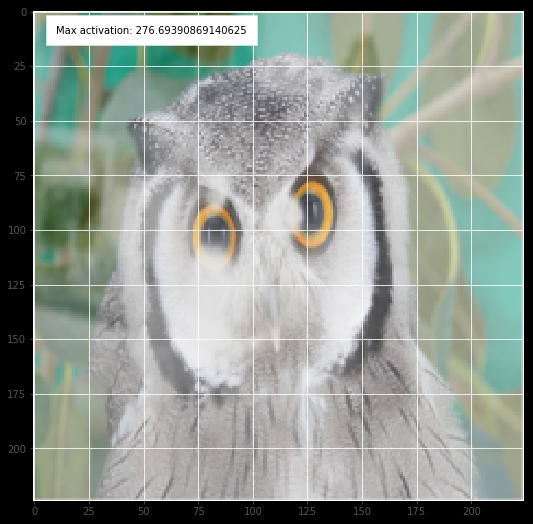

In [504]:
activation_map = activation_maps[0, :, :, 1]
masked_image = generate_masked_image(model_input[0], activation_map)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(masked_image)
ax.text(10, 10, f'Max activation: {np.max(activation_map.flatten())}', bbox={'facecolor': 'white', 'pad': 10})

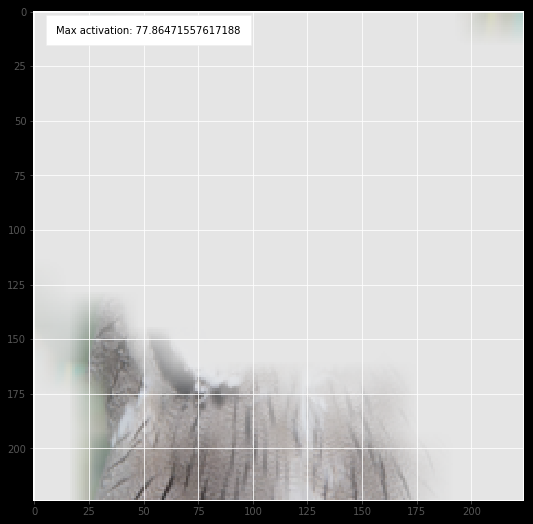

In [274]:
activation_map = activation_maps[:, :, 88]
masked_image = generate_masked_image(model_input[0], activation_map)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(masked_image)
ax.text(10, 10, f'Max activation: {np.max(activation_map.flatten())}', bbox={'facecolor': 'white', 'pad': 10})

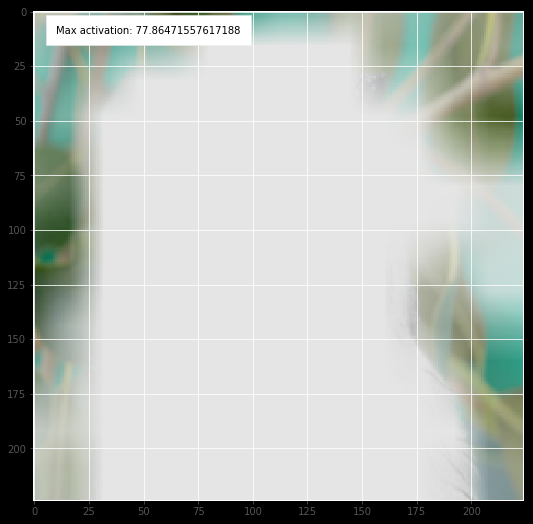

In [242]:
activation_map = activation_maps[:, :, 56]
masked_image = generate_masked_image(model_input[0], activation_map)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(masked_image)
ax.text(10, 10, f'Max activation: {np.max(activation_map.flatten())}', bbox={'facecolor': 'white', 'pad': 10})

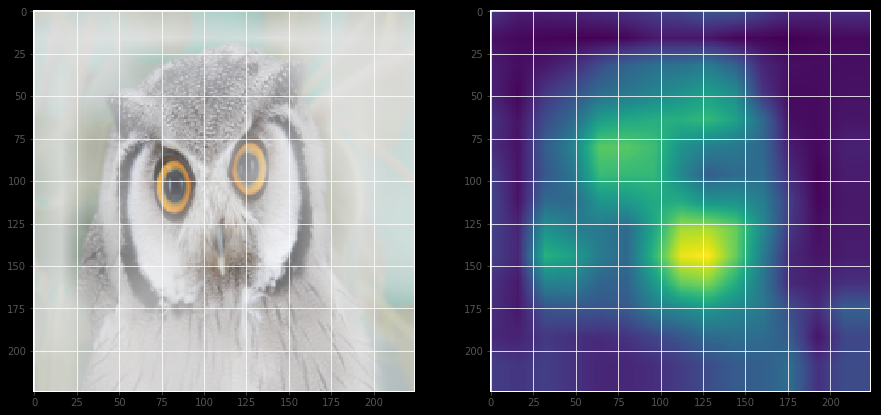

In [278]:
full_activation_map = np.sum(activation_maps, 2)

masked_image = generate_masked_image(model_input[0], full_activation_map)

fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(masked_image)
ax[1].imshow(full_activation_map)

# Class activation maps

Если в качестве классификатора используется единственный полносвязный слой то можно построить очень эффективную визуализацию - CAM (class activation map). Для этого карты активации для каждого признака достаточно домножить на вес данного признака в итоговом классификаторе. В результате мы "подсветим" регион изображения, который с точки зрения сети характерен для данного класса.

<img src="img/cam.jpg"/>



# GradCAM

<img src="img/gradcam.jpg"/>

[Демо](http://gradcam.cloudcv.org/classification)

# Нахождение изображений максимизирующих класс

Это очень простая и эффективная техника для понимания и отладки сети

<table width="100%">
<tr>
<td><img src="data/max_im/prob/prob_0004.jpg"/></td>
<td><img src="data/max_im/prob/prob_0062.jpg"/></td>
<td><img src="data/max_im/prob/prob_0984.jpg"/></td>
</tr>
</table>

# Нахождение изображений максимизирующих выход определённого нейрона

<table width="100%">
<tr>
<td><img src="data/max_im/conv5/conv5_0045.jpg"/></td>
<td><img src="data/max_im/conv5/conv5_0253.jpg"/></td>
<td><img src="data/max_im/conv5/conv5_0209.jpg"/></td>
</tr>
</table>

# Нахождение изображений максимизирующих выход определённого нейрона

<table width="100%">
<tr>
<td><img src="data/max_im/conv2/conv2_0015.jpg"/></td>
<td><img src="data/max_im/conv2/conv2_0102.jpg"/></td>
<td><img src="data/max_im/conv2/conv2_0254.jpg"/></td>
<td><img src="data/max_im/conv2/conv2_0084.jpg"/></td>
<td><img src="data/max_im/conv2/conv2_0215.jpg"/></td>
</tr>
</table>

# Генерация изображений

In [282]:
def build_backprop_model(model, loss):
    gradients = K.gradients(loss, model.input)[0]
    gradients /= (K.sqrt(K.mean(K.square(gradients))) + 1e-5)
    return K.function([model.input], [loss, gradients])

In [523]:
filter_max_loss = - K.mean(model.get_layer('block1_conv1').output[:, :, :, 55])
backprop = build_backprop_model(model, filter_max_loss)

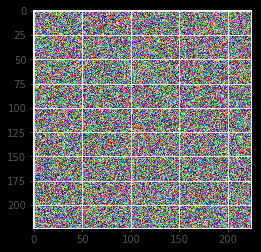

In [524]:
random_image = np.random.rand(224, 224, 3)
plt.imshow(random_image)

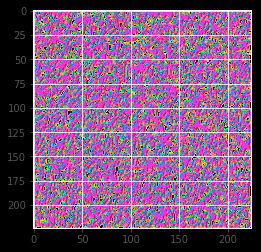

In [525]:
loss, gradient = backprop([np.expand_dims(random_image, 0)])
gradient = gradient[0]
plt.imshow(gradient)

In [526]:
random_image = np.random.rand(1, 224, 224, 3)
random_image = random_image / np.max(random_image)
num_iterations = 1000
l = 0.1

for i in range(num_iterations):
    loss, gradient = backprop([random_image])
    random_image = np.clip(random_image - l * gradient, 0, 1)
    if i % 250 == 0:
        print(f'\rIteration: {i:<5} Loss: {loss}')

Iteration: 0     Loss: -0.14151281118392944
Iteration: 250   Loss: -1.0273441076278687
Iteration: 500   Loss: -1.0273503065109253
Iteration: 750   Loss: -1.0273503065109253


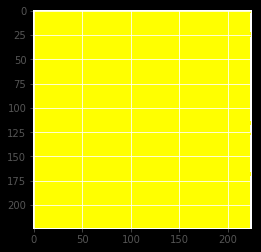

In [527]:
plt.imshow(random_image[0])

# Deep Visualizations

Если эту операцию провести на более глубоких слоях с дополнительной регуляризацией ( L2 decay ) - то можно получить психоделические картинки:

<img src="img/dreams.png"/>

In [528]:
single_class_loss = - K.mean(model.get_layer("predictions").output[:,9])
backprop = build_backprop_model(model, single_class_loss)

In [529]:
random_image = np.random.rand(1, 224, 224, 3)
num_iterations = 300
l = 0.01

for i in range(num_iterations):
    loss, gradient = backprop([random_image])
    random_image = random_image - l * gradient
    if i % 100 == 0:
        print(f'\rIteration: {i:<5} Loss: {loss}')

Iteration: 0     Loss: -0.0001403481001034379
Iteration: 100   Loss: -0.0013273496879264712
Iteration: 200   Loss: -0.9544821977615356


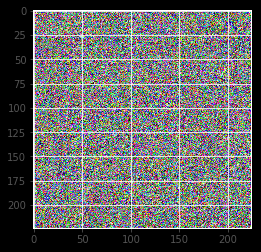

In [530]:
plt.imshow(random_image[0])

In [531]:
predicted_classes = model.predict(random_image)
decode_predictions(predicted_classes, top=5)

[[('n01518878', 'ostrich', 0.99828809),
  ('n02018795', 'bustard', 0.00055640802),
  ('n02012849', 'crane', 0.00017989177),
  ('n02437312', 'Arabian_camel', 0.00011035339),
  ('n01616318', 'vulture', 6.5022679e-05)]]

<img src="img/ostrich.jpg"/>

<img src="img/fooling.jpeg"/>